# Advanced Analysis

This notebook extends the evaluation of your SWIFT routing testing framework.

:::warning Note
This notebook assumes that the merged DataFrame (`merged_df`) is available from the Basic Analytics notebook. If not, the code below will attempt to reload the data.
:::

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.calibration import calibration_curve

# Retrieve connection string and recreate engine
%store -r db_uri
from sqlalchemy import create_engine
engine = create_engine(db_uri)
print("Engine recreated from stored connection string.")

# Retrieve merged_df from Basic Analytics notebook
%store -r merged_df

try:
    merged_df
    print("merged_df is available.")
except NameError:
    print("merged_df is not defined. Reloading from database...")
    import pandas as pd
    expected_df = pd.read_sql("SELECT * FROM expected_results", engine)
    actual_df = pd.read_sql("SELECT * FROM actual_results", engine)
    print("Merged DataFrame recreated from the database.")

Engine recreated from stored connection string.
merged_df is available.


### Additional Metrics and Visualizations

Below we compute advanced evaluation metrics. In this example, we demonstrate ROC curve and calibration plot generation, as well as computing the Matthews Correlation Coefficient and Cohen's Kappa. This demonstration assumes a binary classification scenario; if you have more classes, consider one-vs-rest methods.

Multiclass scenario detected. Computing one-vs-rest ROC curves.


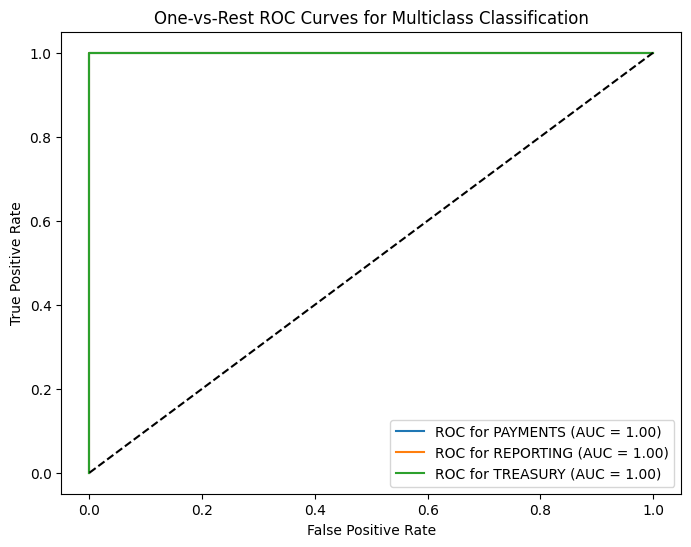

Calibration plot not implemented for multiclass scenario in this example.
Matthews Correlation Coefficient (MCC) (multiclass): 1.00
Cohen's Kappa (multiclass): 1.00


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.calibration import calibration_curve

unique_labels = merged_df['expected_label'].str.upper().unique()

if len(unique_labels) == 2:
    sorted_labels = sorted(unique_labels)
    pos_label = sorted_labels[1]
    
    y_true = (merged_df['expected_label'].str.upper() == pos_label).astype(int)
    
    y_score = merged_df['confidence']
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10)
    
    plt.figure(figsize=(8,6))
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Plot')
    plt.legend()
    plt.show()
    
    y_pred_binary = (merged_df['predicted_label'].str.upper() == pos_label).astype(int)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    kappa = cohen_kappa_score(merged_df['expected_label'].str.upper(), 
                              merged_df['predicted_label'].str.upper())
    
    print(f"Matthews Correlation Coefficient (MCC): {mcc:0.2f}")
    print(f"Cohen's Kappa: {kappa:0.2f}")
    
else:
    print("Multiclass scenario detected. Computing one-vs-rest ROC curves.")
    
    unique_labels = np.sort(merged_df['expected_label'].str.upper().unique())
    n_classes = len(unique_labels)
    
    from sklearn.preprocessing import label_binarize
    y_true_multi = label_binarize(merged_df['expected_label'].str.upper(), classes=unique_labels)
    
    y_score_multi = np.zeros((merged_df.shape[0], n_classes))
    for i, row in merged_df.iterrows():
        pred_class = row['predicted_label'].upper()
        # Get the index of the predicted class in unique_labels
        if pred_class in unique_labels:
            class_idx = list(unique_labels).index(pred_class)
            y_score_multi[i, class_idx] = row['confidence']
    
    # Compute ROC curve and AUC for each class
    plt.figure(figsize=(8,6))
    from sklearn.metrics import roc_curve, auc
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_multi[:, i], y_score_multi[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC for {unique_labels[i]} (AUC = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('One-vs-Rest ROC Curves for Multiclass Classification')
    plt.legend(loc='lower right')
    plt.show()
    
    print("Calibration plot not implemented for multiclass scenario in this example.")
    
    mcc = matthews_corrcoef(merged_df['expected_label'].str.upper(), 
                             merged_df['predicted_label'].str.upper())
    kappa = cohen_kappa_score(merged_df['expected_label'].str.upper(), 
                              merged_df['predicted_label'].str.upper())
    
    print(f"Matthews Correlation Coefficient (MCC) (multiclass): {mcc:0.2f}")
    print(f"Cohen's Kappa (multiclass): {kappa:0.2f}")

In [9]:
%store mcc
%store kappa

Stored 'mcc' (float64)
Stored 'kappa' (float64)
